In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
stock='GOOG'
# Assume we have time series data for stock prices
# Use 'Adjusted Close' 
df_stock = pd.read_csv(f'./data/{stock}_weekly_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
ddf_stock=df_stock.sort_index(ascending=True,inplace=True)

ts = df_stock['Adjusted Close'].values

# Use the 'Adjusted Close' prices for analysis
ts = df_stock['Adjusted Close'].values

# Normalize the actual prices
scaler = MinMaxScaler()
ts = ts.reshape(-1, 1)  # Reshape for scaler
ts_scaled = scaler.fit_transform(ts)

# Define a function to create sequences of data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    dates=[]
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        dates.append(df_stock.index[i + time_step])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y),dates

# Set time step for LSTM
time_step = 10  # Number of previous days to use for predicting the next day
X, y,dates = create_dataset(ts_scaled, time_step)

# Reshape input for LSTM [samples, time steps, features]
# X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Ridge model
ridge = Ridge(alpha=0.01)  # alpha is the regularization strength; higher alpha means stronger regularization

# Train the model
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# RidgeCV performs cross-validation to find the best alpha
alphas = np.logspace(-6, 6, 13)  # A range of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Best alpha found via cross-validation
print(f'Best alpha: {ridge_cv.alpha_}')



Mean Squared Error: 0.0003579683702126206
Best alpha: 0.01


/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [2]:
inp=pd.DataFrame(X.reshape(X.shape[0],X.shape[1]))
inp['y']=y
inp['predictions']=ridge.predict(X)
inp.tail()
inp_scaled=scaler.inverse_transform(inp)
# inp_scaled['date']=dates
ridge_df=pd.DataFrame(inp_scaled,columns=inp.columns)


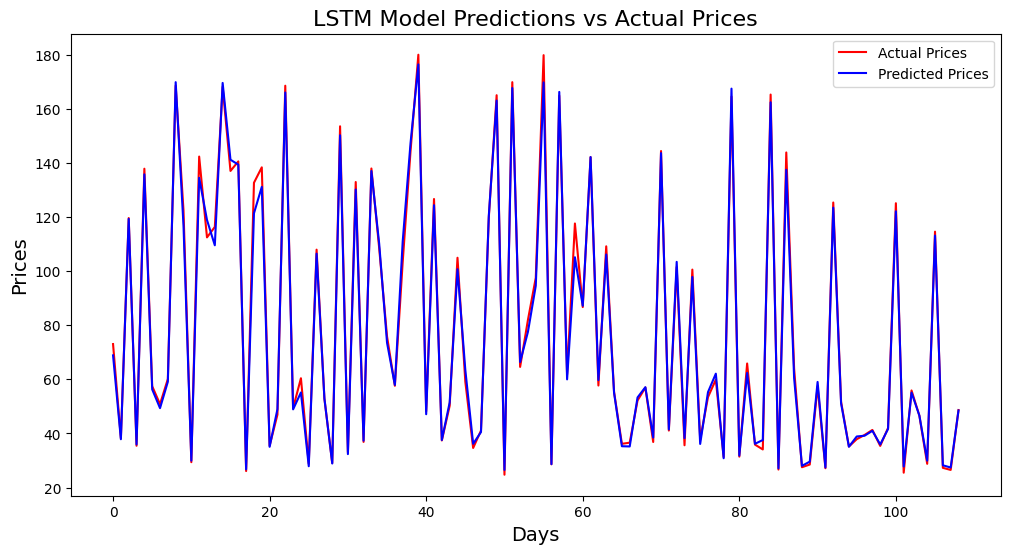

In [3]:
# Make predictions
predictions = ridge.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions = scaler.inverse_transform(predictions.reshape(1,-1)).reshape(-1,1)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('LSTM Model Predictions vs Actual Prices', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

In [4]:
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(x=dates[-len(y_test_scaled):], y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=dates[-len(y_test_scaled):], y=predictions.reshape(1,-1)[0], mode='lines', name='predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

X_in = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, batch_size=32, epochs=100)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.1102
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0140
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0044
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - lo

In [6]:
inp=pd.DataFrame(X.reshape(X.shape[0],X.shape[1]))
inp['y']=y
inp['predictions']=model.predict(X)
inp.tail()
inp_scaled=scaler.inverse_transform(inp)
lstm_predictions=pd.DataFrame(inp_scaled,columns=inp.columns)
lstm_predictions['ridge_predictions']=ridge_df['predictions']


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [7]:
import plotly.express as px
import plotly.graph_objects as go

trace1 = go.Scatter(x=df_stock.index[time_step:], y=lstm_predictions['y'], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=df_stock.index[time_step:], y=lstm_predictions['predictions'], mode='lines', name='predicted')
trace3 = go.Scatter(x=df_stock.index[time_step:], y=lstm_predictions['ridge_predictions'], mode='lines', name='ridge predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2,trace3], layout=layout)

# Show the plot
fig.show()

In [8]:

def accuracy(df_forecast, y_train_series, seasonallity):

    method = df_forecast.columns[1:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []
    dir_accuracy_results=[]
    
    def directional_accuracy(y_true, y_pred):
    # Compare directions of changes
        y_true_dir = np.sign(np.diff(y_true))
        y_pred_dir = np.sign(np.diff(y_pred))
        return np.mean(y_true_dir == y_pred_dir)

    y = df_forecast.y.values
    scale = np.abs(y_train_series[:-seasonallity] - y_train_series[seasonallity:])
    scale = np.average(scale)

    for i in method:

        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs(d/y))*100
        mase = mae_f / scale
        dir_accuracy=directional_accuracy(y,y_hat)
        mae_results.append(np.round(mae_f,2))
        rmse_results.append(np.round(rmse_f,2))
        mape_results.append(np.round(mape,2))
        mase_results.append(np.round(mase,2))
        dir_accuracy_results.append(np.round(dir_accuracy,2))

    accuracy_df = pd.DataFrame({'Method':method,
                    'RMSE':rmse_results,
                    'MAE':mae_results,
                    'MAPE':mape_results,
                    'MASE':mase_results,
                   'DA':dir_accuracy_results })

    return accuracy_df

In [9]:
predictions_df=lstm_predictions[['y','predictions','ridge_predictions']]
predictions_df['lag']=predictions_df['y'].shift(1)
predictions_df.dropna(inplace=True)


/var/folders/65/vkw7fp891gz53dgtj8svj4n80000gn/T/ipykernel_21342/3127785279.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/65/vkw7fp891gz53dgtj8svj4n80000gn/T/ipykernel_21342/3127785279.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# predictions_df=lstm_predictions[['y','predictions','ridge_predictions']]
# predictions_df.columns
accuracy(predictions_df, lstm_predictions['y'].values, time_step)

,Method,RMSE,MAE,MAPE,MASE,DA
0,predictions,4.92,3.57,4.46,0.52,0.49
1,ridge_predictions,3.42,2.28,2.81,0.33,0.49
2,lag,3.49,2.31,2.81,0.33,0.48
